In [1]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_turbo'
run_name = 'parallel_eps5'
source_dir = '../../Kite_par/data/'+system_name+'/'+run_name+'/'
data_dir = '../data/'+system_name+'/'+run_name+'_eval/'
plot_dir = '../../Kite_par/plots/'+system_name+'/'+run_name+'/'

## Evaluate

In [2]:
# READING THE ENVIRONMENTAL PARAMETERS
env_params = ut.read_params(source_dir+'param_env.txt')
for ep in env_params:
    print(ep, env_params[ep])
alg_params = ut.read_params(source_dir+'param_alg.txt')
for ep in alg_params:
    print(ep, alg_params[ep])
#eps = ut.p_law_burn(alg_params['n_steps'], alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc'])

int_steps 0.001
ep_length 600.0
ep_length_eval 600.0
decision_time 0.25
alphas [ 18.  20.]
CL_alphas [ 1.1   1.05]
CD_alphas [ 0.18  0.21]
init_theta 1.0471975511965976
init_dtheta 0.0
init_alpha 1.0
beta_bins [-1.57079633 -1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293
  0.52359878  0.87266463  1.22173048  1.57079633]
banks [-0.26179939 -0.20943951 -0.15707963 -0.10471976 -0.05235988  0.
  0.05235988  0.10471976  0.15707963  0.20943951  0.26179939]
init_bank 5.0
init_phi 0.0
init_dphi 0.0
wind_type turbo
wind_amplification 1.0
windv_file_dir ../../Kite_power/data/kite3d_turbo/v1/
windv_file_name velocities
windq_file_path ../../Kite_power/data/kite3d_turbo/q.txt
start_frame 1000.0
alg_type sarsa
gamma 1.0
n_steps 60000000.0
traj_points 1000.0
lr0 0.1
lr1 0.01
n0 10000.0
lrc 400000.0
lr_expn 0.6
lr_burn0 30000000.0
lr_burn1 30000000.0
eps0 0.01
epsc 400000.0
eps_expn 1.0
eps_burn 20000000.0
init_quals 3000.0


In [3]:
#WRITING THE EVALUATION PARAMETERS
params = dict()
params['alg_type'] = 'eval'
params['quality_path'] = source_dir+'/best_quality.txt'
params['ev_time'] = 10000 # sec
params['n_steps'] = params['ev_time']/float(env_params['decision_time'])+1
params['traj_points'] = params['n_steps']
params['gamma'] = 1
params['epsilon'] = 0
#params['epsilon'] = eps
ut.write_params(params, data_dir, 'param_alg.txt')

env_params['ep_length'] = 600
env_params['init_alpha'] = len(env_params['alphas'])+1
env_params['init_bank'] = int(len(env_params['banks'])+1)
ut.write_params(env_params, data_dir, 'param_env.txt')


In [4]:
p = subprocess.Popen(["./run.exe", system_name, run_name+'_eval'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))


In [6]:
s_traj, s_head = ut.read_traj(data_dir + 'ev_states.txt')


In [7]:
print(len(s_traj))


40002


In [8]:
#xs = np.linspace(0, params['n_steps']*env_params['decision_time'], int(params['n_steps'])+1)
xs = np.linspace(0, (len(s_traj)-1)*env_params['decision_time'], len(s_traj))


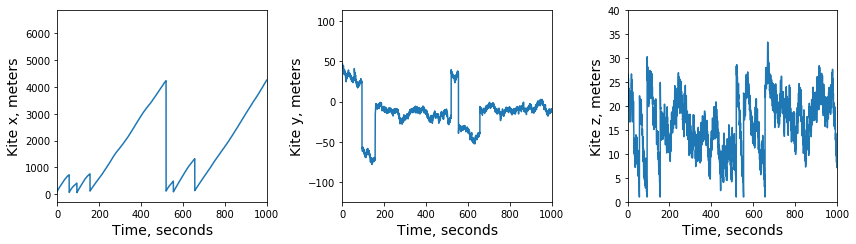

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))

lim = [0,1000]

ax1.set_xlim(lim)
ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Kite x, meters', fontsize=14)
#ax1.set_ylim(0,700)
ax1.plot(xs, s_traj[:,0])

ax2.set_xlim(lim)
#ax2.set_ylim(-40,10)
ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Kite y, meters', fontsize=14)
ax2.plot(xs, s_traj[:,1])

ax3.set_xlim(lim)
ax3.set_ylim(0,40)
ax3.set_xlabel('Time, seconds', fontsize=14)
ax3.set_ylabel('Kite z, meters', fontsize=14)
ax3.plot(xs, s_traj[:,2])

plt.tight_layout()
plt.savefig(plot_dir+"eval_traj_ind.png", dpi=200)
plt.show()

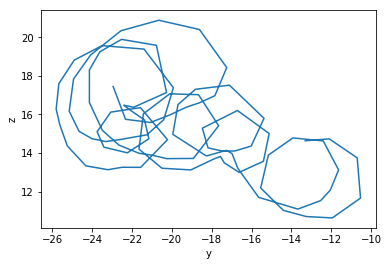

In [10]:
y = []
z = []
for i in range(1600,1700):
    y.append(s_traj[i][1])
    z.append(s_traj[i][2])
plt.plot(y,z)
plt.xlabel("y")
plt.ylabel("z")
plt.show()

In [11]:
aggr_s_traj, labels = ut.read_traj(data_dir+'ev_aggr_st.txt')
aggr_s_i_traj = np.array(aggr_s_traj[:,0], dtype=int)

In [12]:
beta_list = []
if system_name != "kite3d":
    for i in range(len(env_params['beta_bins'])-1):
        beta_list.append((env_params['beta_bins'][i] + env_params['beta_bins'][i+1])/2.0)
else:
    beta_list.append(0)
    env_params['beta_bins'] = np.linspace(-np.pi/2, np.pi/2, 2)
    #env_params['beta_bins'].append(-np.pi/2)
    #env_params['beta_bins'].append(np.pi/2)


In [13]:
print(env_params['beta_bins'])

[-1.57079633 -1.22173048 -0.87266463 -0.52359878 -0.17453293  0.17453293
  0.52359878  0.87266463  1.22173048  1.57079633]


In [14]:
def aggr_state_index_translator(index, n_betas, n_banks):
    beta = index % n_betas
    rest = index // n_betas
    bank = rest % n_banks
    alpha = rest // n_banks
    return beta, bank, alpha

In [15]:
beta_i, bank_i, alpha_i = aggr_state_index_translator(aggr_s_i_traj, len(env_params['beta_bins'])-1, len(env_params['banks']))
alphas = np.take(env_params['alphas'], alpha_i)
banks = np.take(env_params['banks'], bank_i)
betas = np.take(beta_list, beta_i)

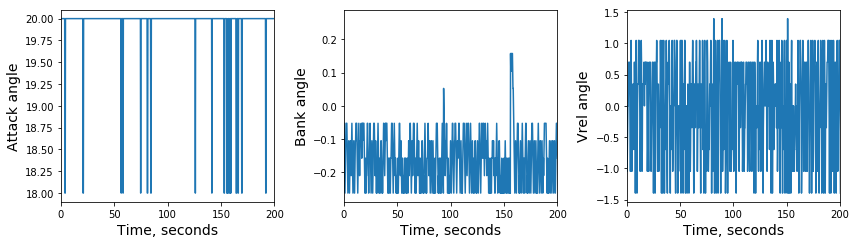

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
x_wind = [0,200]

ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Attack angle', fontsize=14)
ax1.set_xlim(x_wind)
ax1.plot(xs, alphas)

ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Bank angle', fontsize=14)
ax2.set_xlim(x_wind)
ax2.plot(xs, banks)

ax3.set_xlabel('Time, seconds', fontsize=14)
ax3.set_ylabel('Vrel angle', fontsize=14)
ax3.set_xlim(x_wind)
ax3.plot(xs, betas)

plt.tight_layout()
plt.savefig(plot_dir+"eval_pol_ind.png", dpi=200)
plt.show()

In [17]:
def bins_from_list(l):
    bins = np.array([(l[i] + l[i+1])/2 for i in range(len(l)-1)])
    bins = np.append(2*l[0] - bins[0], bins)
    bins = np.append(bins, 2*l[-1] - bins[-1])
    return bins

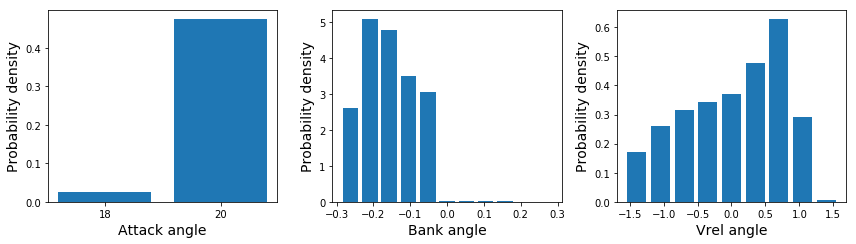

In [18]:
if system_name != "kite3d":
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
else:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3.5))

ax1.set_ylabel('Probability density', fontsize=14)
ax1.set_xlabel('Attack angle', fontsize=14)
bins = bins_from_list(env_params['alphas'])
ax1.set_xticks(env_params['alphas'])
ax1.hist(alphas, bins=bins, align='mid', rwidth=0.8, density=True)

ax2.set_ylabel('Probability density', fontsize=14)
ax2.set_xlabel('Bank angle', fontsize=14)
bins = bins_from_list(env_params['banks'])
#ax2.set_xticks(env_params['banks'])
ax2.hist(banks, bins=bins, align='mid', rwidth=0.8, density=True)

if system_name != "kite3d":
    ax3.set_ylabel('Probability density', fontsize=14)
    ax3.set_xlabel('Vrel angle', fontsize=14)
    bins = bins_from_list(beta_list)
    #ax2.set_xticks(env_params['banks'])
    ax3.hist(betas, bins=bins, align='mid', rwidth=0.8, density=True)

plt.tight_layout()
plt.savefig(plot_dir+"aggr_states_ind.png", dpi=200)
plt.show()

In [19]:
return_s_traj, head = ut.read_traj(data_dir+'return_traj.txt')
return_i_steps = np.array(return_s_traj[:,1], dtype=int)

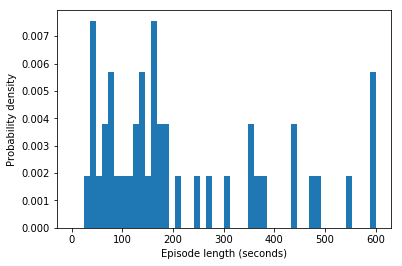

In [20]:
g=plt.hist(return_i_steps/4, bins = 50, range = (0,601), density = True, stacked = True)
plt.xlabel('Episode length (seconds)')
plt.ylabel('Probability density')
#plt.lim(0,1000)
plt.savefig(plot_dir+"hist_endtimes.png", dpi=200)
plt.show()

In [42]:
print(12.02*g[0])
for i in range(50):
    g[0][i]=12.02*g[0][i]

[ 0.          0.          0.          0.          0.02173913  0.
  0.02173913  0.          0.          0.02173913  0.02173913  0.04347826
  0.02173913  0.02173913  0.02173913  0.02173913  0.02173913  0.02173913
  0.          0.          0.          0.02173913  0.          0.          0.
  0.          0.          0.02173913  0.          0.04347826  0.02173913
  0.02173913  0.02173913  0.          0.          0.          0.02173913
  0.02173913  0.          0.          0.06521739  0.02173913  0.          0.
  0.          0.          0.          0.          0.          0.45652174]


In [43]:
integ = 0
tot = 0
for i in range(49):
    integ += g[0][i]
print(integ)

for i in range(50):
    tot += g[0][i]
print(tot*12.02)
print(integ/tot)

0.54347826087
12.02
0.54347826087


In [44]:
print(s_traj[return_i_steps[0]-1,0]-s_traj[0,0])
print(s_traj[return_i_steps[0]-1,0])
print(s_traj[0,0])

5781.1151
5880.03
98.9149


In [45]:
distances = np.zeros(len(return_i_steps))
s = -1
for i in range(len(return_i_steps)):
    s += return_i_steps[i]
    #print(s_traj[s,0], s_traj[s+1,0])
    distances[i] = s_traj[s,0]

In [46]:
distances_norm = np.zeros(len(return_i_steps))
s = -1
for i in range(len(return_i_steps)):
    s = s+return_i_steps[i]
    distances_norm[i] = s_traj[s,0] - s_traj[s+1-return_i_steps[i],0]
    

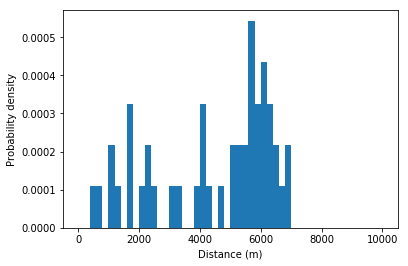

In [47]:
h=plt.hist(distances_norm, bins = 50, range = (0, 10000), density = True)
plt.xlabel('Distance (m)')
plt.ylabel('Probability density')
#plt.xlim(0,10000)
plt.savefig(plot_dir+"hist_enddistnorm.png", dpi=200)
plt.show()

In [23]:
print(h)

(array([   0.,    5.,    8.,   20.,   60.,   43.,   38.,   31.,   53.,
         56.,   48.,   45.,   45.,   34.,   18.,   23.,   25.,   36.,
         37.,   34.,   35.,   19.,   46.,   68.,  111.,  124.,  145.,
        135.,  118.,  116.,  111.,  132.,  214.,  115.,   30.,    4.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.]), array([     0.,    200.,    400.,    600.,    800.,   1000.,   1200.,
         1400.,   1600.,   1800.,   2000.,   2200.,   2400.,   2600.,
         2800.,   3000.,   3200.,   3400.,   3600.,   3800.,   4000.,
         4200.,   4400.,   4600.,   4800.,   5000.,   5200.,   5400.,
         5600.,   5800.,   6000.,   6200.,   6400.,   6600.,   6800.,
         7000.,   7200.,   7400.,   7600.,   7800.,   8000.,   8200.,
         8400.,   8600.,   8800.,   9000.,   9200.,   9400.,   9600.,
         9800.,  10000.]), <a list of 50 Patch objects>)


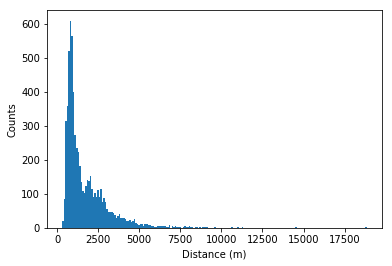

In [37]:
k=plt.hist(distances, bins = 200, density = False)
plt.xlabel('Distance (m)')
plt.ylabel('Counts')
#plt.xlim(0,10000)
plt.savefig(plot_dir+"hist_enddist.png", dpi=200)
plt.show()

In [38]:
print(k)

(array([  21.,   85.,  315.,  360.,  520.,  610.,  566.,  401.,  272.,
        234.,  222.,  182.,  135.,  108.,  103.,  122.,  140.,  137.,
        154.,  114.,   90.,  103.,   92.,  111.,   92.,  115.,   77.,
         87.,   77.,   56.,   48.,   48.,   48.,   44.,   38.,   29.,
         34.,   42.,   30.,   28.,   29.,   27.,   19.,   21.,   22.,
         18.,   21.,   25.,   15.,   10.,    9.,   10.,   11.,    6.,
         10.,   10.,    9.,    7.,    6.,    5.,    3.,    3.,    5.,
          6.,    4.,    6.,    6.,    4.,    2.,    3.,    7.,    0.,
          5.,    2.,    5.,    2.,    3.,    3.,    0.,    2.,    4.,
          2.,    3.,    6.,    1.,    1.,    0.,    3.,    3.,    0.,
          1.,    0.,    1.,    1.,    1.,    2.,    0.,    0.,    0.,
          0.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    1.,    0.,    0.,    0.,    1.,    0.,
          0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.

In [25]:
distances_stop = []
s = -1
for i in range(len(return_i_steps)):
    s+=return_i_steps[i]
    #print(s_traj[s,0], s_traj[s-10,0])
    if abs(s_traj[s,0] - s_traj[s-10, 0]) < 5:
        #distances_stop.append(s_traj[s,0]-s_traj[s-return_i_steps[i]+1,0])
        distances_stop.append(s_traj[s,0])

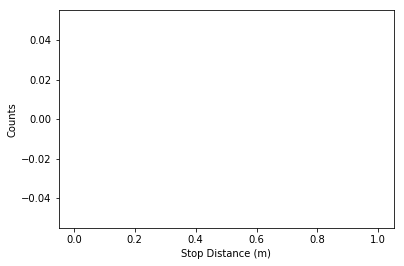

In [26]:
plt.hist(distances_stop, bins = 50, density = False)
plt.xlabel('Stop Distance (m)')
plt.ylabel('Counts')
#plt.xlim(0,2500)
plt.savefig(plot_dir+"hist_enddist_stop.png", dpi=200)
plt.show()

In [71]:
np.argmax(h[0])

85

In [72]:
h[0][85]

408.0

In [76]:
h[1][84]

591.03389439999989

In [77]:
h[1][86]

602.99132759999986